# Firefighters

## Load the data

In [1]:
import numpy as np
import pandas as pd

colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

def is_top_scoring(x,thresh_ltn,thresh_cpt):
    return 1 if ((x[0]=='Captain' and x[1] >= thresh_cpt) or (x[0]=='Lieutenant' and x[1] >= thresh_ltn)) else 0

def get_top_scoring(df, n_ltn, n_cpt):
    thresh_ltn = min(df.groupby('Position')['Combine'].nlargest(n_ltn+2)['Captain'])
    thresh_cpt = min(df.groupby('Position')['Combine'].nlargest(n_cpt+2)['Lieutenant'])
    return df[['Position','Combine']].apply(is_top_scoring, args=(thresh_ltn,thresh_cpt), axis=1)

def get_features(df, top_k_thresh, top_k_2y_thresh):
    passed = df['Combine'].apply(lambda x: int(x >= 70)).rename('Passed')
    top_scoring = get_top_scoring(df, top_k_thresh[0], top_k_thresh[1]).rename('Top_k')
    top_scoring2 = get_top_scoring(df, top_k_2y_thresh[0], top_k_2y_thresh[1]).rename('Top_k_2y')
    return pd.concat([top_scoring, top_scoring2, passed, df], axis=1)

data = pd.read_csv('../data/Firefighters.csv')  # load data set
data = get_features(data, (8,7), (16,8))
data.head(10)

,Top_k,Top_k_2y,Passed,Race,Position,Oral,Written,Combine
0,1,1,1,W,Captain,89.52,95,92.808
1,1,1,1,W,Captain,80.00,95,89.000
2,1,1,1,W,Captain,82.38,87,85.152
3,0,0,1,W,Captain,88.57,76,81.028
4,0,0,1,W,Captain,76.19,84,80.876
5,0,0,1,H,Captain,76.19,82,79.676
6,0,0,1,W,Captain,76.19,82,79.676
7,0,0,1,H,Captain,70.00,84,78.400
8,0,0,1,W,Captain,73.81,81,78.124
9,0,0,1,W,Captain,84.29,72,76.916


## Visualize distributions and adverse impact by position, race and test score

In [2]:
from scipy import stats  
import numpy as np  
import matplotlib.pylab as plt

plt.rcParams["figure.figsize"] = [24,18]

def plot(df, title, figname):
    scores = [70,min(df[df['Top_k_2y']==1]['Combine']),min(df[df['Top_k']==1]['Combine'])]
    lines = []
    fig, ax = plt.subplots(3,4)#,sharey=True)
    for i, race in enumerate(['W','B','H',None]):
        ax[0,i].set_title(race if not race is None else 'All')
        for j, key in enumerate(['Written','Oral','Combine']):
            if i==0:
                ax[j,3].yaxis.set_label_position("right")
                ax[j,3].set_ylabel(key, size='large')
            if not race is None:
                ser = df[df['Race']==race][key]
            else:
                ser = df[key]
            # Mean, passing and promotion scores
            ax[j,i].axvline(x=ser.mean(), color=colors[i], linestyle='dashed', linewidth=1)
            for x in scores:
                ax[j,i].axvline(x=x, color='#5f5f5f', linewidth=1)
            # Plot histogram
            ser.hist(density=True,ax=ax[j,i],color=colors[i],alpha = 0.5)
            xt = ax[j,i].get_xticks()  
            lnspc = np.linspace(40, 100, len(ser))
            # Fit normal distribrace andution
            mu, stdev = stats.norm.fit(ser)
            pdf_g = stats.norm.pdf(lnspc, mu, stdev)
            ax[j,i].plot(lnspc, pdf_g, label="Norm",color=colors[i]) 
            ax[j,3].plot(lnspc, pdf_g, label="Norm",color=colors[i]) 
    plt.suptitle(title,fontsize=28,y=0.94)
    if len(figname)>0:
        fig.savefig(figname)
    
def get_summary(df):
    passed = df.groupby(['Race','Passed']).size().unstack().fillna(0)
    top_k = df.groupby(['Race','Top_k']).size().unstack().fillna(0)
    top_k_2y = df.groupby(['Race','Top_k_2y']).size().unstack().fillna(0)
    summary =  pd.DataFrame({
        'Race': ['B','H','W','M'], 
        'Pass': [passed[1]['B'],passed[1]['H'],passed[1]['W'],passed[1]['B']+passed[1]['H']],
        'Pass_pr': [0,0,0,0],
        'Fail': [passed[0]['B'],passed[0]['H'],passed[0]['W'],passed[0]['B']+passed[0]['H']],
        'Total': [0,0,0,0],
        'Top_k': [top_k[1]['B'],top_k[1]['H'],top_k[1]['W'],top_k[1]['B']+top_k[1]['H']],
        'Top_k_2y': [top_k_2y[1]['B'],top_k_2y[1]['H'],top_k_2y[1]['W'],top_k_2y[1]['B']+top_k_2y[1]['H']],
        'Top_k_2y_pr': [0,0,0,0],
    })
    summary['Total'] = summary['Pass'] + summary['Fail']
    summary['Pass_pr'] = 100*summary['Pass']/summary['Total']
    summary['Adverse_impact'] = (100*summary['Pass_pr']/max(summary['Pass_pr']))
    summary['Top_k_2y_pr'] = 100*summary['Top_k_2y']/summary['Total']
    summary['Adverse_impact_2y'] = (100*summary['Top_k_2y_pr']/max(summary['Top_k_2y_pr']))
    
    return summary

### Lieutenant

In [3]:
summary = get_summary(data[data["Position"]=="Lieutenant"])
summary

,Race,Pass,Pass_pr,Fail,Total,Top_k,Top_k_2y,Top_k_2y_pr,Adverse_impact,Adverse_impact_2y
0,B,6,31.578947,13,19,0.0,4.0,21.052632,54.315789,56.578947
1,H,3,20.000000,12,15,0.0,0.0,0.000000,34.400000,0.000000
2,W,25,58.139535,18,43,12.0,16.0,37.209302,100.000000,100.000000
3,M,9,26.470588,25,34,0.0,4.0,11.764706,45.529412,31.617647


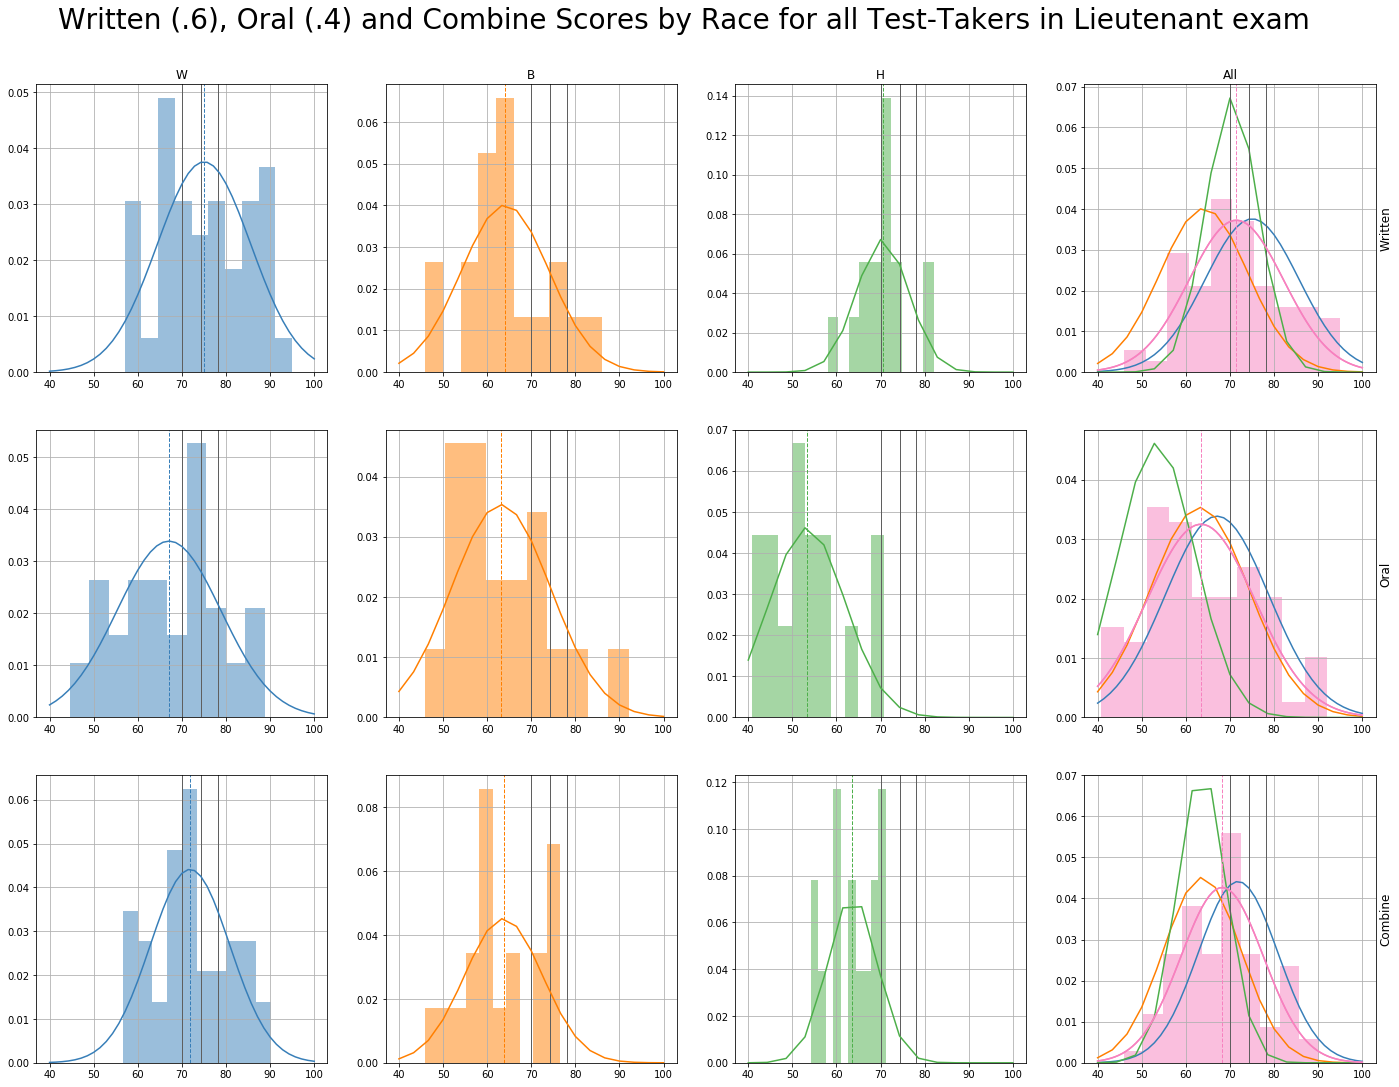

In [4]:
plt.rcParams["figure.figsize"] = [24,18]
plot(data[data["Position"]=="Lieutenant"],"Written (.6), Oral (.4) and Combine Scores by Race for all Test-Takers in Lieutenant exam", "../images/ff_orig_ltn_race2score.png")

### Captain exam

In [5]:
get_summary(data[data["Position"]=="Captain"])

,Race,Pass,Pass_pr,Fail,Total,Top_k,Top_k_2y,Top_k_2y_pr,Adverse_impact,Adverse_impact_2y
0,B,3,37.5,5,8,0.0,0.0,0.0,58.59375,0.0
1,H,3,37.5,5,8,0.0,0.0,0.0,58.59375,0.0
2,W,16,64.0,9,25,3.0,3.0,12.0,100.00000,100.0
3,M,6,37.5,10,16,0.0,0.0,0.0,58.59375,0.0


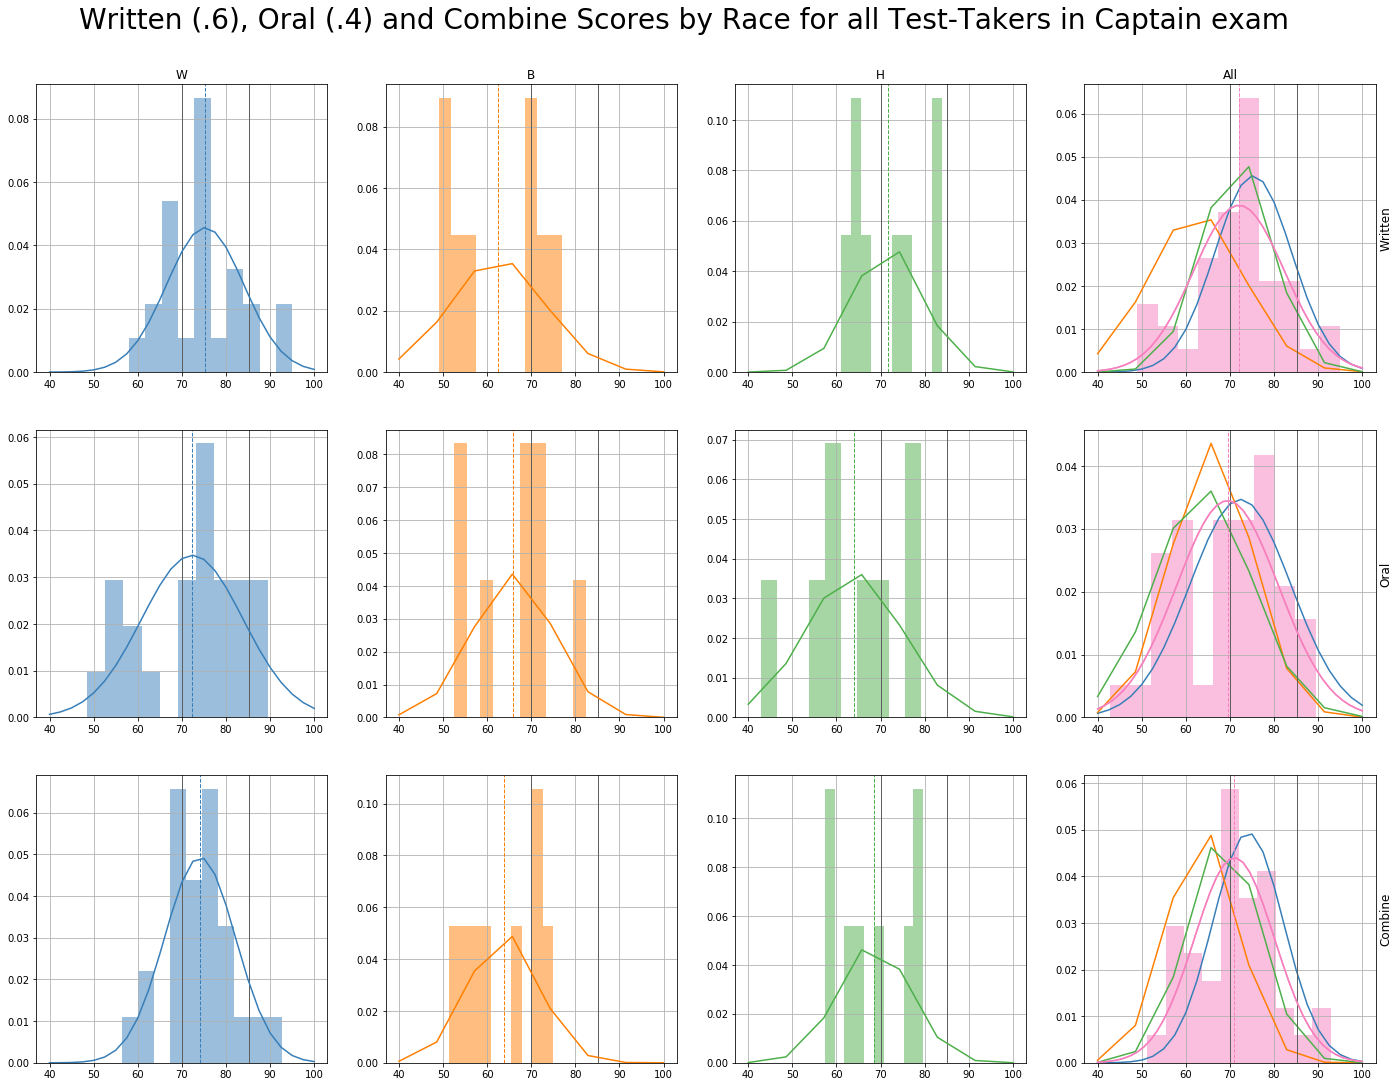

In [6]:
plot(data[data["Position"]=="Captain"],"Written (.6), Oral (.4) and Combine Scores by Race for all Test-Takers in Captain exam", "../images/ff_orig_cpt_race2score.png")

## Adverse impact ratio as a function of exam scaling

In [7]:
scale = np.array(range(0,11))/10
ai_ratios = {}

for position in ['Lieutenant', 'Captain']:
    ai_ratio_H, ai_ratio_B, ai_ratio_M = [], [], []
    for i, q in enumerate(scale):
        df = pd.read_csv('../data/Firefighters.csv')  # load data set
        df['Combine'] = df.apply(lambda x: (q*x.Oral+(1-q)*x.Written), axis=1)
        df = get_features(df, (8,7), (16,8))
        summary = get_summary(df[df['Position']==position])
        ai_ratio_H.append(list(summary[summary.Race=='H']['Adverse_impact'])[0])
        ai_ratio_B.append(list(summary[summary.Race=='B']['Adverse_impact'])[0])
        ai_ratio_M.append(list(summary[summary.Race=='M']['Adverse_impact'])[0])
    ai_ratios[position] = {'H': ai_ratio_H, 'B': ai_ratio_B, 'M': ai_ratio_M}

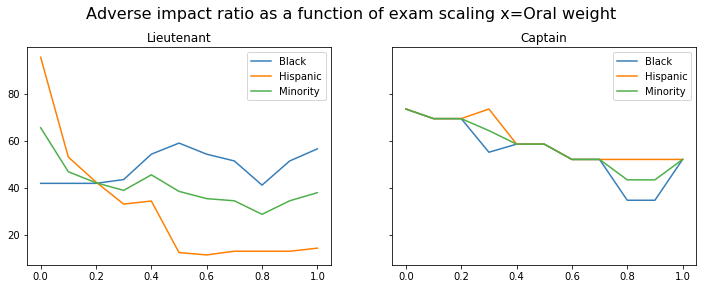

In [8]:
plt.rcParams["figure.figsize"] = [12,4]
fig, ax = plt.subplots(1, 2,sharey=True)
for i, position in enumerate(['Lieutenant', 'Captain']):
    ax[i].set_title(position)
    ax[i].plot(scale, ai_ratios[position]['B'], label='Black', color=colors[0])
    ax[i].plot(scale, ai_ratios[position]['H'], label='Hispanic', color=colors[1])
    ax[i].plot(scale, ai_ratios[position]['M'], label='Minority', color=colors[2])
    ax[i].legend()

plt.suptitle('Adverse impact ratio as a function of exam scaling x=Oral weight',fontsize=16,y=1.02)
plt.show()

## Revise exam weights, compute new Combined score

In [9]:
oral=.2
data_w8o2 = pd.read_csv('../data/Firefighters.csv')  # load data set
data_w8o2['Combine'] = data_w8o2.apply(lambda x: (oral*x.Oral+(1-oral)*x.Written), axis=1)
data_w8o2 = get_features(data_w8o2, (8,7), (16,8))

get_summary(data_w8o2[data_w8o2['Position']=='Lieutenant'])

,Race,Pass,Pass_pr,Fail,Total,Top_k,Top_k_2y,Top_k_2y_pr,Adverse_impact,Adverse_impact_2y
0,B,5,26.315789,14,19,2,5,26.315789,41.910331,59.556787
1,H,4,26.666667,11,15,1,2,13.333333,42.469136,30.175439
2,W,27,62.790698,16,43,15,19,44.186047,100.000000,100.000000
3,M,9,26.470588,25,34,3,7,20.588235,42.156863,46.594427


In [10]:
get_summary(data_w8o2[data_w8o2['Position']=='Captain'])

,Race,Pass,Pass_pr,Fail,Total,Top_k,Top_k_2y,Top_k_2y_pr,Adverse_impact,Adverse_impact_2y
0,B,4,50.0,4,8,0.0,0.0,0.0,69.444444,0.0
1,H,4,50.0,4,8,0.0,0.0,0.0,69.444444,0.0
2,W,18,72.0,7,25,3.0,3.0,12.0,100.000000,100.0
3,M,8,50.0,8,16,0.0,0.0,0.0,69.444444,0.0


## Fairness-awareness - Disparate Impact Removal


### IBM 360 Fairness Kit (Disparate Impact Removal)

In [11]:
import pandas as pd
import numpy as np

data = pd.read_csv('../data/Firefighters.csv')  # load data set
data['Passed'] = data.apply(lambda x: int(x['Combine']>=70), axis=1)
print(data)

    Race    Position   Oral  Written  Combine  Passed
0      W     Captain  89.52       95   92.808       1
1      W     Captain  80.00       95   89.000       1
2      W     Captain  82.38       87   85.152       1
3      W     Captain  88.57       76   81.028       1
4      W     Captain  76.19       84   80.876       1
..   ...         ...    ...      ...      ...     ...
113    H  Lieutenant  40.83       64   54.732       0
114    B  Lieutenant  52.08       56   54.432       0
115    H  Lieutenant  48.33       58   54.132       0
116    B  Lieutenant  52.92       49   50.568       0
117    B  Lieutenant  45.83       46   45.932       0

[118 rows x 6 columns]


In [12]:
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC as SVM

from tqdm import tqdm

    
def computeDIs(df, repair_levels):
    
    protected = 'Race'
    data_set = StandardDataset(
        df=df, 
        label_name='Passed',favorable_classes=[1],
        protected_attribute_names=[protected], privileged_classes=[(lambda x: x=='W')],
        features_to_keep=['Oral','Written'])

    scaler = MinMaxScaler(copy=False) # Scale values between 0 and 1

    #train, test = data_set.split([len(data_set.features)]) 
    train = data_set.copy()
    train.features = scaler.fit_transform(data_set.features)
    index = train.feature_names.index(protected)
    
    """
    train, test = data_set.split([int(.6*len(data_set.features))]) 

    train.features = scaler.fit_transform(train.features)
    test.features = scaler.fit_transform(test.features)
    index = train.feature_names.index(protected)
    """

    DIs = []
    features = []
    for level in tqdm(repair_levels*1.0):

        di = DisparateImpactRemover(repair_level=level)
        train_repd = di.fit_transform(train)
        
        X_tr = np.delete(train_repd.features, index, axis=1)
        y_tr = train_repd.labels.ravel()
        
        lmod = LogisticRegression(class_weight='balanced', solver='liblinear')
        lmod.fit(X_tr, y_tr)
        
        train_repd_pred = train_repd.copy()
        train_repd_pred.labels = lmod.predict(X_tr)
        
        features.append(train_repd_pred.features.flatten())
        
        p = [{protected: 1}]
        u = [{protected: 0}]
        cm = BinaryLabelDatasetMetric(train_repd_pred, privileged_groups=p, unprivileged_groups=u)
        DIs.append(cm.disparate_impact())
        
        """
        di = DisparateImpactRemover(repair_level=level)
        train_repd = di.fit_transform(train)
        test_repd = di.fit_transform(test)

        X_tr = np.delete(train_repd.features, index, axis=1)
        X_te = np.delete(test_repd.features, index, axis=1)
        y_tr = train_repd.labels.ravel()

        lmod = LogisticRegression(class_weight='balanced', solver='lbfgs')
        lmod.fit(X_tr, y_tr)

        test_repd_pred = test_repd.copy()
        test_repd_pred.labels = lmod.predict(X_te)

        p = [{protected: 1}]
        u = [{protected: 0}]
        cm = BinaryLabelDatasetMetric(test_repd_pred, privileged_groups=p, unprivileged_groups=u)
        DIs.append(cm.disparate_impact())
        """
    
    return DIs, features


100%|██████████| 11/11 [00:00<00:00, 144.29it/s]
/home/laihoeev/anaconda3/envs/twml/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


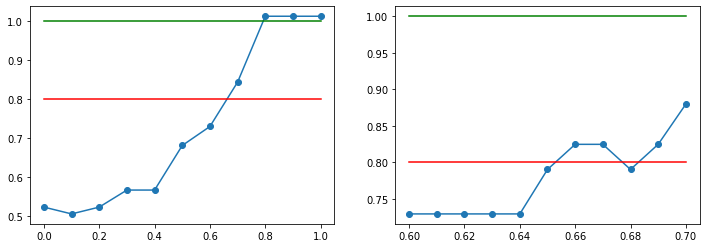

In [13]:
import matplotlib.pyplot as plt

#%matplotlib notebook

repair_levels = np.linspace(0, 1, 11)
DIs, features = computeDIs(data[data['Position']=='Lieutenant'], repair_levels)

fig, ax = plt.subplots(1,2)
ax[0].plot(repair_levels, DIs, marker='o')
ax[0].plot([0, 1], [1, 1], 'g')
ax[0].plot([0, 1], [0.8, 0.8], 'r')

repair_levels = np.linspace(0.6, 0.7, 11)
DIs, features = computeDIs(data[data['Position']=='Lieutenant'], repair_levels)

ax[1].plot(repair_levels, DIs, marker='o')
ax[1].plot([0.6, 0.7], [1, 1], 'g')
ax[1].plot([0.6, 0.7], [0.8, 0.8], 'r')

plt.show()




In [14]:
columns = {0: 'Passed', 1: 'Oral', 2: 'Written'}

#features
df = pd.DataFrame(features).transpose()
df['Changed'] = (df.values == df.values[:, [0]]).all(axis=1)
df['Column'] = [columns[x] for x in (df.index.values % 3)]
df[df['Changed']]

,0,1,2,3,4,5,6,7,8,9,10,Changed,Column
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,True,Passed
1,0.935024,0.935024,0.935024,0.935024,0.935024,0.935024,0.935024,0.935024,0.935024,0.935024,0.935024,True,Oral
2,0.775510,0.775510,0.775510,0.775510,0.775510,0.775510,0.775510,0.775510,0.775510,0.775510,0.775510,True,Written
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,True,Passed
4,0.780488,0.780488,0.780488,0.780488,0.780488,0.780488,0.780488,0.780488,0.780488,0.780488,0.780488,True,Oral
...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,0.235902,0.235902,0.235902,0.235902,0.235902,0.235902,0.235902,0.235902,0.235902,0.235902,0.235902,True,Oral
227,0.061224,0.061224,0.061224,0.061224,0.061224,0.061224,0.061224,0.061224,0.061224,0.061224,0.061224,True,Written
228,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,True,Passed
229,0.097561,0.097561,0.097561,0.097561,0.097561,0.097561,0.097561,0.097561,0.097561,0.097561,0.097561,True,Oral


(array([77.,  0.,  0.,  0.,  0., 41.,  0.,  0.,  0., 55.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

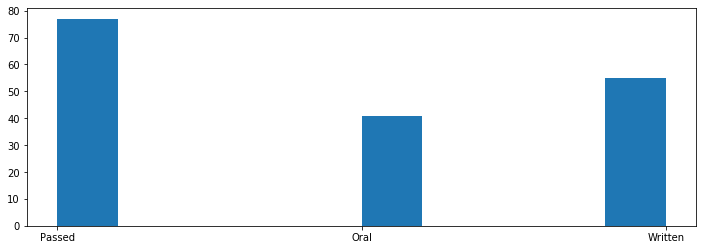

In [15]:
plt.hist(df[df['Changed']]['Column'])